In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn 
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import sys

current_folder_path = os.path.abspath('')

## Loading the labeled dataset
The numpy array has the following shapes :
- 6556 rows, reprensenting 6556 event occurences
- 1445 columns representing :  
-- 1 column of step value (initialized for every serie id (ie test subject))  
-- 721 columns of **anglez** samples, centered 30 minutes before and after an event  
-- 721 columns of **enmo** samples, centered 30 minutes before and after an event  
-- 1 column of timestamp, ie the moment of the sample   
-- 1 column of **event** which is the **target** of the dataset. (0: *onset*, 1: *wakeup*)  

In [2]:
offset = 12
data = np.load(f"{current_folder_path}/training_data/data_{offset}.npy")
print(data.shape)

#[step, :, :, timestamp, event]
step = data[:,0]
X = data[:, 1:-2] #1:-2 to load only anglez and 
Y = data[:, -1]


(6563, 53)


## Data splitting
The parquet dataset, loaded as an edited npy array, is divided into training and testing datasets

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

train_features = torch.from_numpy(X_train).float()
train_labels = torch.from_numpy(Y_train).float().unsqueeze(1)
test_features = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(Y_test).float().unsqueeze(1)

train_features = F.normalize(train_features)
test_features = F.normalize(test_features)

# train_features = train_features.unsqueeze(1)
# test_features = test_features.unsqueeze(1)

print(train_features.size(), train_labels.size(), test_features.size(), test_labels.size())

torch.Size([4922, 50]) torch.Size([4922, 1]) torch.Size([1641, 50]) torch.Size([1641, 1])


## NN architecture

In [44]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.hidden_size= hidden_size
        self.output_size = output_size
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.input_layer = nn.Linear(input_size, hidden_size)
        
        self.layer1 = nn.Linear(hidden_size, hidden_size//2)
        self.layer2 = nn.Linear(hidden_size//2, hidden_size//4)
        
        self.batchnorm1 = nn.BatchNorm1d(hidden_size//2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size//4)

        self.output_layer = nn.Linear(hidden_size//4, output_size)
        self.sigmoid = nn.Sigmoid()  
        self.dropout = nn.Dropout1d(p=0.1)
            
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        x = self.output_layer(x)  
        #x = self.relu(x)    
        x = self.sigmoid(x)
        return x
    

class SignalCNN(nn.Module):
    def __init__(self, input_size, in_channels, num_classes):
        super(SignalCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.fc1 = nn.Linear(176 * 4, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x
    

class SignalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SignalRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.rnn(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out



## Model training

4922 50


  1%|          | 1/100 [00:00<00:12,  7.73it/s]

100%|██████████| 100/100 [00:04<00:00, 20.78it/s]

Epoch 100, Loss: 59.543324172496796, Final Loss: 0.5505289435386658


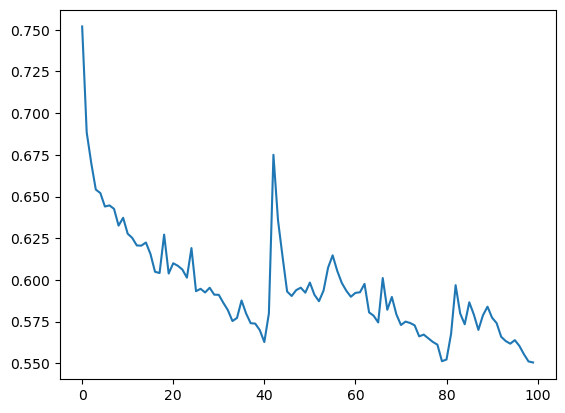

In [47]:

batch, input_size = train_features.size()
print(batch, input_size)

model = SimpleNN(input_size, hidden_size=64, output_size=1)
criterion = nn.BCELoss()

# model = SignalCNN(input_size=input_size, in_channels=in_channels, num_classes=1)
# # criterion = nn.Softmax()
# criterion = nn.BCELoss()

# model = SignalRNN(input_size=1, hidden_size=64, num_layers=2, num_classes=2)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimize = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

model.train() 
running_loss = 0.0

losses_list = []
# num_epochs = int(input("Number of epochs : ")) 
num_epochs = 100   
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(train_features)

    #print(outputs.data[0:10])
    
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    losses_list.append(loss.item())

print(f"Epoch {epoch+1}, Loss: {running_loss}, Final Loss: {losses_list[-1]}")
#print(np.round(losses_list[::2], 6))

import matplotlib.pyplot as plt
plt.plot(losses_list)


## Model testing
#### Testing dataset (X_test)

In [49]:

model.eval()
correct = 0
total = 0
with torch.no_grad():
    outputs = model(test_features) 
    #print(test_features[0:10])
    print(outputs[0:10].T)
    #predicted = torch.round(outputs.data)
    #_, predicted = torch.max(outputs.data, 1)
    predicted = torch.round(outputs.data)
    # predicted = np.round(outputs.numpy())
    total += test_labels.size(0)
    # correct += (predicted.numpy() == test_labels.numpy().T).sum().item()
    correct += (predicted == test_labels).sum().item()        
    
    print(predicted[0:10].T)
    print(test_labels[0:10].T)
    #print(predicted.numpy()[0:10].T, test_labels.numpy().T[0, 0:10])
    #correct += (predicted == test_labels.numpy().T[0]).sum().item()
    # print(total, correct)

    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

tensor([[0.2306, 0.3446, 0.2893, 0.4193, 0.3149, 0.3767, 0.2837, 0.0841, 0.3079,
         0.3190]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 1., 0., 1., 1., 1., 1., 0., 1., 1.]])
Accuracy on test set: 51.31%


## Model application
#### Data visualization

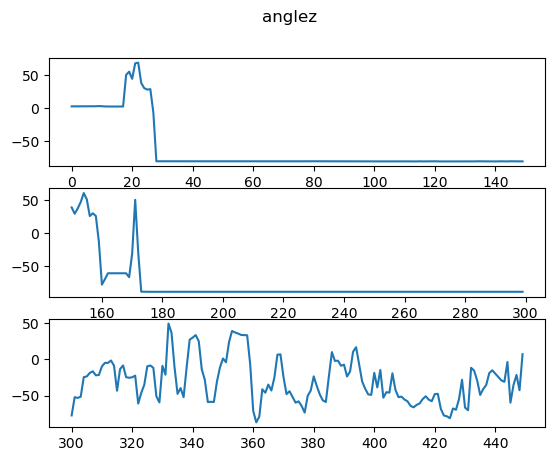

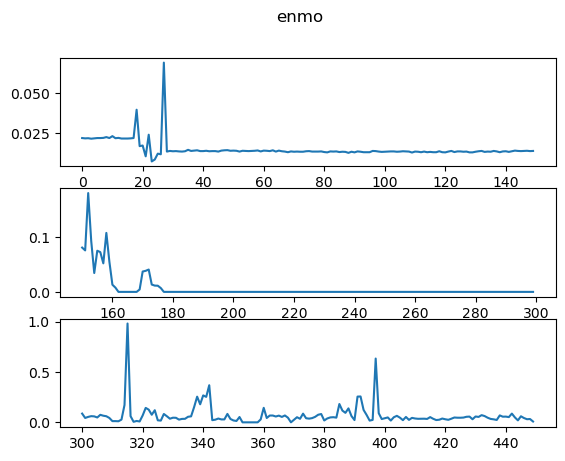

In [54]:
data = pd.read_parquet(f"{current_folder_path}/test_series.parquet")

plt.subplots(3, 1)
plt.suptitle("anglez")
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.plot(data["anglez"][k*150:(k+1)*150])

plt.subplots(3, 1)
plt.suptitle("enmo")
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.plot(data["enmo"][k*150:(k+1)*150])

#### Submission dataset (X_sub)

In [80]:
offset = 12

data_sub = np.load(f"{current_folder_path}/submission_col.npy", allow_pickle=True)

"""
Data as DataFrame to to np array, where axis=serie_id, columns=(anglez, enmo)
"""
#[series_id, step, anglez, enmo, timestamp]
series_id = data_sub[:, 0]
step = data_sub[:, 1]
anglez = np.array([data_sub[:, 2]])
enmo = np.array([data_sub[:, 3]])
timestamp = np.array([data_sub[:, 4]])

unique_series_id = np.array([np.unique(series_id)])

array1 = np.concatenate([anglez[0, 0:150], enmo[0, 0:150], timestamp[0, 0:150]]).reshape(1, 450)
array2 = np.concatenate([anglez[0, 150:300], enmo[0, 150:300], timestamp[0, 150:300]]).reshape(1, 450)
array3 = np.concatenate([anglez[0, 300:450], enmo[0, 300:450], timestamp[0, 300:450]]).reshape(1, 450)

# serie 1 : [anglez (150), enmo (150), timestamp (150)]
# serie 2 : [anglez (150), enmo (150), timestamp (150)]
# serie 3 : [anglez (150), enmo (150), timestamp (150)]
array = np.concatenate([array1, array2, array3], axis=0)
print(array.shape)

if False:
    plt.subplots(3, 1)
    plt.suptitle("anglez")
    for k in range(3):
        plt.subplot(3, 1, k+1)
        plt.plot(array[k, 0:150])

    plt.subplots(3, 1)
    plt.suptitle("enmo")
    for k in range(3):
        plt.subplot(3, 1, k+1)
        plt.plot(array[k, 150:300])

"""
Model evaluation, as a 'convolution of learned patterns' over the sample
"""
missed_values = []
outputs_arrays = np.zeros((3, 1))
for conv_step in tqdm(range(offset, 150-offset, 1)):
    # print(conv_step)
    # X_sub_offset is a [sample_of_anglez, sample_of_enmo] concatenation
    X_sub_offset = np.concatenate([array[:, conv_step-offset : conv_step+offset], 
                                   array[:, 150+conv_step-offset : 150+conv_step+offset]], axis=1)

    output_array = np.zeros((3, 1))
    for serie_idx in range(3):
        # X_sub_idx is the sample of only one of the 3 test subjects
        X_sub_idx = X_sub_offset[serie_idx, :]
        X_sub_idx = np.array([np.pad(X_sub_idx, 1, mode="edge").astype(np.float32)])

        #print(serie_idx, X_sub_idx.shape)

        submission_features = torch.from_numpy(X_sub_idx).float()
        submission_features = F.normalize(submission_features)
        # submission_features = submission_features.unsqueeze(1)

        # print(submission_features.size())
        if submission_features.size() == torch.Size([1, 50]):
            model.eval()
            with torch.no_grad():
                output_array[serie_idx, 0] = model(submission_features).numpy()

    outputs_arrays = np.concatenate([outputs_arrays, output_array], axis=1)
    m, n = output_array.shape

# print(outputs_arrays[0, 0:10])
# print(outputs_arrays[0, -10:])
# print(submission_features.shape)
# print(outputs_arrays)

submission_array = np.zeros((1, 5))
for serie_id in range(3):
    pred_onset = min(outputs_arrays[serie_id, 1:-1])
    step_onset = outputs_arrays[serie_id, :].tolist().index(pred_onset)

    pred_wakeup = max(outputs_arrays[serie_id, 1:-1])
    step_wakeup = outputs_arrays[serie_id, :].tolist().index(pred_wakeup)

    pred_event = max(1-pred_onset, pred_wakeup)
    if pred_event == 1-pred_onset:
        step_event = outputs_arrays[serie_id, :].tolist().index(pred_onset)
        pred_event = round(pred_onset)
        score = 1-pred_onset

    elif pred_event == pred_wakeup:
        step_event = outputs_arrays[serie_id, :].tolist().index(pred_onset)
        pred_event = round(pred_wakeup)
        score = pred_wakeup

    else:
        print("pred error")

    # print(f"\nSERIE {serie_id+1}")
    # print(f"step onset = {step_onset}, event = {round(pred_onset)}")
    # print(f"step wakeup = {step_wakeup}, event = {round(pred_wakeup)}")
    # print(f"step event réel = {step_event}, event reel = {pred_event}")

    submission_array = np.concatenate([submission_array, np.array([[serie_id, "serie_id", step_event, pred_event, score]])], axis=0)

submission_array = submission_array[1:, :]
submission_array[:,0] = submission_array[:,0].astype(np.float32)
submission_array[:,1] = submission_array[:,1].astype(str)
submission_array[:,2] = submission_array[:,2].astype(np.float32)
submission_array[:,3] = submission_array[:,3].astype(np.float32)
submission_array[:,4] = submission_array[:,4].astype(np.float32)

submission_array[submission_array[:, 3] == "0"] = "onset"
submission_array[submission_array[:, 3] == "1"] = "wakeup"

submission_df = pd.DataFrame(submission_array, columns=["row_id", "serie_id", "step", "event", "score"])

submission_df[["serie_id"]] = np.array([["038441c925bb", "03d92c9f6f8a", "0402a003dae9"]]).T
display(submission_df.head())

submission_df.to_csv(f"{current_folder_path}/submission.csv", index=False)


# print(max(outputs_arrays[0, :]))
# print(X_sub_idx)
# print(submission_features)
# print(X_sub_idx.shape)


        






(3, 450)


100%|██████████| 126/126 [00:00<00:00, 359.97it/s]


,row_id,serie_id,step,event,score
0,0.0,038441c925bb,26.0,0.0,0.9591593
1,1.0,03d92c9f6f8a,9.0,0.0,0.9644713
2,2.0,0402a003dae9,59.0,0.0,0.9827751


## Past versions
Not working codes, but kept as reference

import matplotlib.pyplot as plt

data_sub = np.load(f"{current_folder_path}/submission.npy")
print(data_sub.shape)

#[step, :, :, timestamp]
step_sub = data_sub[:,0]
X_sub = data_sub[:, 1:-1]
print(X_sub.shape)

target_len = 302
padding_len = (target_len - X_sub.shape[1])//2
X_sub = np.pad(X_sub, padding_len, mode="edge")[padding_len:-padding_len, :]
print(X_sub.shape)

submission_features = torch.from_numpy(X_sub).float()
submission_features = F.normalize(submission_features)
print(submission_features.size())

#### Submission csv

df_sample_submission = pd.read_csv(f"{current_folder_path}/sample_submission.csv")
columns=np.array([df_sample_submission.columns])
col = df_sample_submission.columns

arr_sample_submission = df_sample_submission.to_numpy()

model.eval()
with torch.no_grad():
    outputs = model(submission_features).numpy()
print(outputs.shape)

len_test = outputs.shape[0]//150
for serie_id in range(len_test):
    answer_array_1 = []
    answer_array_2 = []

    # Row id 
    answer_array_1.append(serie_id*2)
    answer_array_2.append(serie_id*2+1)

    # series_id
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 1])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 1])

    print(answer_array_1)

    current_serie = outputs.tolist()[serie_id:serie_id+150]
    print(np.round(current_serie[0:10], 3).T)
    score_onset, step_onset = min(current_serie), current_serie.index(min(current_serie))
    score_wakeup, step_wakeup = max(current_serie), current_serie.index(max(current_serie))

    print(score_onset, step_onset)
    print(score_wakeup, step_wakeup)

    # step
    answer_array_1.append(step_onset)
    answer_array_2.append(step_wakeup)

    # event
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 3])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 3])

    # score
    answer_array_1.append(score_onset[0])
    answer_array_2.append(score_wakeup[0])

    # saving the submission
    arr_sample_submission[serie_id*2,:] = np.array(answer_array_1)
    arr_sample_submission[serie_id*2+1,:] = np.array(answer_array_2)

arr_sample_submission = np.concatenate([columns, arr_sample_submission], axis=0)
header = arr_sample_submission[0,:]
# Extract the data (excluding the header)
data = arr_sample_submission[1:,:]
# Create a Pandas DataFrame with the header
df = pd.DataFrame(data, columns=header)
#df.to_csv(f"{current_folder_path}/submission.csv", index=False)
#np.savetxt(f"{current_folder_path}/anwer_sheet.txt", arr_sample_submission, delimiter=',')